In [20]:
import pandas as pd
import numpy as np
import gymnasium as gym
import random

import seaborn as sns
import matplotlib.pyplot as plt

import plottingepi


from collections import defaultdict
import itertools

from myQwordleEnv import WordleMetaEnv, WordleQEnv, MyAgent
from tqdm import tqdm
import time

In [2]:
f = open('target_words.txt', 'r')
target_words = f.read().splitlines()
f.close()

In [3]:
len(target_words)

2309

In [4]:
# TODO:
"""
Make plot for which actions were chosen most of the time by the age nt by the meta learning agent
Change the 6 moves to 7 moves if lose cause 6 moves is still winning
"""

'\nMake plot for which actions were chosen most of the time by the age nt by the meta learning agent\nChange the 6 moves to 7 moves if lose cause 6 moves is still winning\n'

We can try a form of Meta-Learning to try to reduce the search space by making the agent learn to choose between few well-defined actions instead

In [5]:
e = WordleMetaEnv()

In [6]:
# this follows the logic we did in class and extension to an action space of length actions_len by being inspired from the epsilon greedy policy implemented here but for BlackJack: https://github.com/dennybritz/reinforcement-learning/blob/master/MC/MC%20Control%20with%20Epsilon-Greedy%20Policies%20Solution.ipynb	
def eps_greedy(Q_table, state, actions_len, eps = 0.1):
	action_probs = np.ones(actions_len, dtype = float) * eps / actions_len
	best_action = np.argmax(Q_table[state])
	action_probs[best_action] += (1.0 - eps + eps/actions_len)
	return action_probs

In [7]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
	"""
	Creates an epsilon-greedy policy based
	on a given Q-function and epsilon.
	
	Returns a function that takes the state
	as an input and returns the probabilities
	for each action in the form of a numpy array
	of length of the action space(set of possible actions).
	"""
	def policyFunction(state):

		Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
		best_action = np.argmax(Q[state])
		Action_probabilities[best_action] += (1.0 - epsilon)
		return Action_probabilities

	return policyFunction


In [8]:
def Q_Learning_old(env, num_episodes, discount_factor = 1.0, alpha = 0.5, eps = 0.3):

    # Action value function
    # A nested dictionary that maps
    # state -> (action -> action-value).
    actions_len = len(env.action_space)
    Q = defaultdict(lambda: np.zeros(actions_len))
    # Keeps track of useful statistics
    stats = plottingepi.EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes))
    win_records = np.zeros(num_episodes)
    
    # Create an eps greedy policy function
    # appropriately for environment action space

    policy = createEpsilonGreedyPolicy(Q, eps, len(env.action_space) )

    wordlistdict = defaultdict()
    
    # For every episode
    for ith_episode in tqdm(range(num_episodes)):

        # Reset the environment and pick the first action
        state = env.reset()
        
        for t in itertools.count():
            #print("this is q", Q)
            # get probabilities of all actions from current state
            # action_probabilities = eps_greedy(Q, state, actions_len, eps)
            action_probabilities = policy(state)
            # choose action according to
            # the probability distribution
            action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)
            # take action and get reward, transit to next state
            next_state, reward, done = env.step(action)
            
            #next_state = sum(next_state)
            
            # Update statistics
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t
            if(env.env.win == 'win'):
                win_records[ith_episode] = 1
            elif(env.env.win == 'lose'):
                win_records[ith_episode] = 0
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])	
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            

            # done is True if episode terminated
            if done:
                break

            state = next_state
        #wordlistdict[env.env.word] = env.tmp_wordlist
            
    return Q, stats, win_records

In [9]:
# qouts9 = []
# souts9 = []
# wouts9 = []
# # why loop?
# for i in range(0,1):
#     # print(i)
#     tmpq, tmps, tmpw = Q_Learning_old(WordleMetaEnv(), 
#                            10000, eps=0.3,alpha=0.02, discount_factor=0.05)
#     qouts9.append(tmpq)
#     souts9.append(tmps)
#     wouts9.append(tmpw)
# print(np.mean([sum(x) for x in wouts9]))

In [10]:
# plt.rcParams['figure.figsize']=7,5
# # plt.style.use('seaborn-white')
# #plt.rcParams['axes.facecolor']='white'
# #plt.rcParams["axes.edgecolor"] = "black"
# #plt.rcParams["axes.linewidth"] = 2
# labels, counts = np.unique(souts9[0].episode_lengths+1, return_counts=True)
# plt.bar(labels, counts, align='center', color='steelblue')

# #plt.hist(s1.episode_lengths+1, bins=10, align='mid')
# #plt.title('10,000 trials', fontsize=24)
# plt.xlabel('game length', fontsize=24)
# plt.ylabel('counts', fontsize=24)
# plt.gca().set_xticks(labels)
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)
# plt.show()

In [11]:
def Q_Learning(env, num_episodes, gamma=1.0, alpha=0.5, epsilon=0.1):
    actions_len = len(env.action_space)
    Q = defaultdict(lambda: np.zeros(actions_len))
    
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    wins = np.zeros(num_episodes)
    
    for i in tqdm(range(num_episodes)):
        state = env.reset()

        # this follows the logic we did in class and extension to an action space of length actions_len by being inspired from the epsilon greedy policy implemented here but for BlackJack: https://github.com/dennybritz/reinforcement-learning/blob/master/MC/MC%20Control%20with%20Epsilon-Greedy%20Policies%20Solution.ipynb
        
        action_probs = np.ones(actions_len, dtype = float) * epsilon / actions_len
        action_prob_len = len(action_probs)
        best_action = np.argmax(Q[state])
        action_probs[best_action] += (1.0 - epsilon + epsilon / actions_len)
        episode_reward = 0
        episode_length = 0
        
        while True:
            # choose action index according to the probability distribution
            action = np.random.choice(np.arange(action_prob_len), p = action_probs / np.sum(action_probs)) # so that add up to one
            next, reward, done = env.step(action)
            episode_reward += reward

            opt_action = np.argmax(Q[next])

            #Q(s,a) ← Q(s,a) + α[ r + γ·max Q(s',a') - Q(s,a) ] 

            new_info = reward + gamma * Q[next][opt_action]
            oldQsa = Q[state][action]
            Q[state][action] += alpha * ( new_info - oldQsa)

            if done:
                episode_lengths[i] = episode_length + 1
                episode_rewards[i] = episode_reward
                if env.env.win == 'win':
                    wins[i] = 1
                elif env.env.win == 'lose':
                    wins[i] = 0
                    episode_lengths[i] = 7
                    
                break
                
            state = next
            episode_length += 1

    stats = {
        'episode_lengths': episode_lengths,
        'episode_rewards': episode_rewards,
        'wins': wins
    }
            
    return Q, stats

In [12]:
def improved_Q_Learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, min_epsilon=0.01, epsilon_decay=0.9995):
    """
    An improved Q-Learning implementation with decaying exploration rate and while loop structure.
    
    Parameters:
    -----------
    env : WordleMetaEnv
        The Wordle environment to learn in
    num_episodes : int
        Number of episodes to train
    discount_factor : float
        Weight for future rewards (gamma)
    alpha : float
        Learning rate
    epsilon : float
        Starting exploration rate
    min_epsilon : float
        Minimum exploration rate
    epsilon_decay : float
        Rate at which epsilon decays after each episode
    
    Returns:
    --------
    tuple
        (Q-table, statistics dictionary)
    """
    # Initialize the Q-table as a nested dictionary
    actions_len = len(env.action_space)
    Q = defaultdict(lambda: np.zeros(actions_len))
    
    # Initialize tracking metrics
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    win_records = np.zeros(num_episodes)
    
    # Keep track of state-action visit counts for adaptive learning rates
    visit_counts = defaultdict(lambda: np.zeros(actions_len))
    
    # Current exploration rate
    epsilon = epsilon
    
    # Loop through episodes
    for episode in tqdm(range(num_episodes)):
        # Reset environment and initialize episode variables
        state = env.reset()
        done = False
        step_count = 0
        total_episode_reward = 0
        
        # Continue until episode is done
        while not done:
            # Determine if we should explore or exploit
            if np.random.random() < epsilon:
                # Exploration: choose a random action
                action = np.random.randint(0, actions_len)
            else:
                # Exploitation: choose the best action from Q-table
                action = np.argmax(Q[state])
            
            # Take action and observe result
            next_state, reward, done = env.step(action)
            total_episode_reward += reward
            
            # Track state-action visit count
            visit_counts[state][action] += 1
            
            # Calculate adaptive learning rate based on visit count
            adaptive_alpha = alpha / (1.0 + visit_counts[state][action] * 0.1)
            
            # Update Q-value using TD learning
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += adaptive_alpha * td_error
            
            # Update state for next iteration
            state = next_state
            step_count += 1
        
        # Record statistics for this episode
        episode_lengths[episode] = step_count
        episode_rewards[episode] = total_episode_reward
        win_records[episode] = 1 if env.env.win == True else 0
        
        # Decay exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        
        # Print progress every 1000 episodes
        if (episode + 1) % 1000 == 0:
            win_rate = np.mean(win_records[max(0, episode-999):episode+1])
            avg_length = np.mean(episode_lengths[max(0, episode-999):episode+1])
            print(f"Episode {episode+1}/{num_episodes} | " +
                  f"Win Rate: {win_rate:.2f} | " +
                  f"Avg Length: {avg_length:.2f} | " +
                  f"Epsilon: {epsilon:.4f}")
    
    # Compile statistics
    stats = {
        'episode_lengths': episode_lengths,
        'episode_rewards': episode_rewards,
        'win_records': win_records,
        'final_epsilon': epsilon
    }
    
    return Q, stats

In [13]:
def plot_game_statistics(stats, window_size=500):
    """
    Plot the trends in Wordle game lengths and rewards
    
    Parameters:
    -----------
    stats : dict
        Dictionary containing episode_lengths and episode_rewards
    window_size : int
        Size of the moving average window for smoothing the trends
    """
    
    # Extract statistics
    episode_lengths = stats['episode_lengths']
    episode_rewards = stats['episode_rewards']
    win_records = stats['wins']
    num_episodes = len(episode_lengths)
    
    # Calculate moving averages for smoothing
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    
    # Create smoothed data
    if num_episodes > window_size:
        ma_lengths = moving_average(episode_lengths, window_size)
        ma_rewards = moving_average(episode_rewards, window_size)
        ma_wins = moving_average(win_records, window_size)
        x_range = np.arange(window_size-1, num_episodes)
    else:
        ma_lengths = episode_lengths
        ma_rewards = episode_rewards
        ma_wins = win_records
        x_range = np.arange(num_episodes)
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Plot game lengths
    ax1.plot(x_range, ma_lengths, 'steelblue', linewidth=2)
    ax1.set_title('Wordle Game Lengths Over Time', fontsize=16)
    ax1.set_ylabel('Number of Guesses', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Plot rewards
    ax2.plot(x_range, ma_rewards, 'forestgreen', linewidth=2)
    ax2.set_title('Wordle Game Rewards Over Time', fontsize=16)
    ax2.set_ylabel('Total Reward', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Plot win rate
    ax3.plot(x_range, ma_wins, 'darkorange', linewidth=2)
    ax3.set_title('Wordle Win Rate Over Time', fontsize=16)
    ax3.set_ylabel('Win Rate', fontsize=14)
    ax3.set_xlabel('Episode', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot the distribution of game lengths
    plt.figure(figsize=(10, 6))
    labels, counts = np.unique(episode_lengths, return_counts=True)
    plt.bar(labels, counts, align='center', color='steelblue')
    plt.xlabel('Game Length (Number of Guesses)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of Wordle Game Lengths', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.xticks(labels)
    plt.show()
    
    # Calculate win statistics
    win_percentage = np.mean(win_records) * 100
    
    # Display summary statistics
    print(f"Win Rate: {win_percentage:.2f}%")
    print(f"Average Game Length: {np.mean(episode_lengths):.2f} guesses")
    print(f"Average Reward: {np.mean(episode_rewards):.2f}")
    
    # Distribution of wins by game length
    if np.sum(win_records) > 0:
        win_lengths = episode_lengths[win_records == 1]
        plt.figure(figsize=(10, 6))
        win_labels, win_counts = np.unique(win_lengths, return_counts=True)
        plt.bar(win_labels, win_counts, align='center', color='forestgreen')
        plt.xlabel('Game Length for Wins (Number of Guesses)', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.title('Distribution of Game Lengths for Wins', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.xticks(win_labels)
        plt.show()

Training Q-learning agent...


100%|██████████| 50000/50000 [05:27<00:00, 152.78it/s]


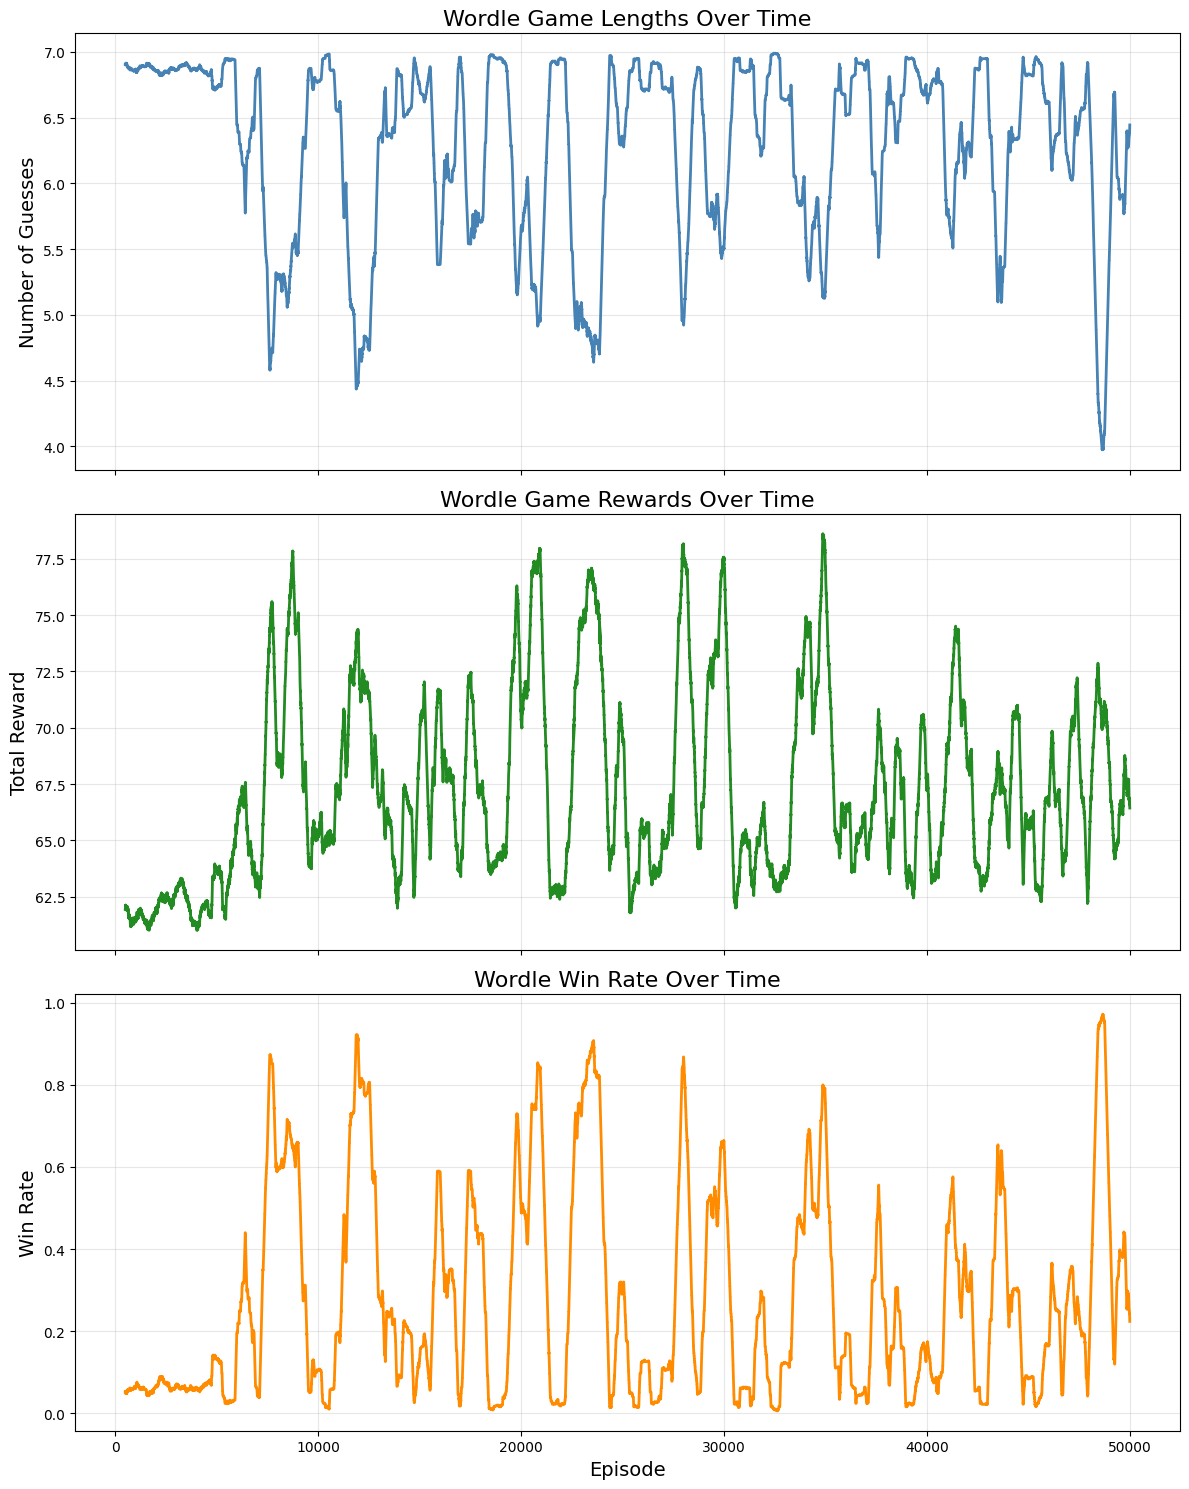

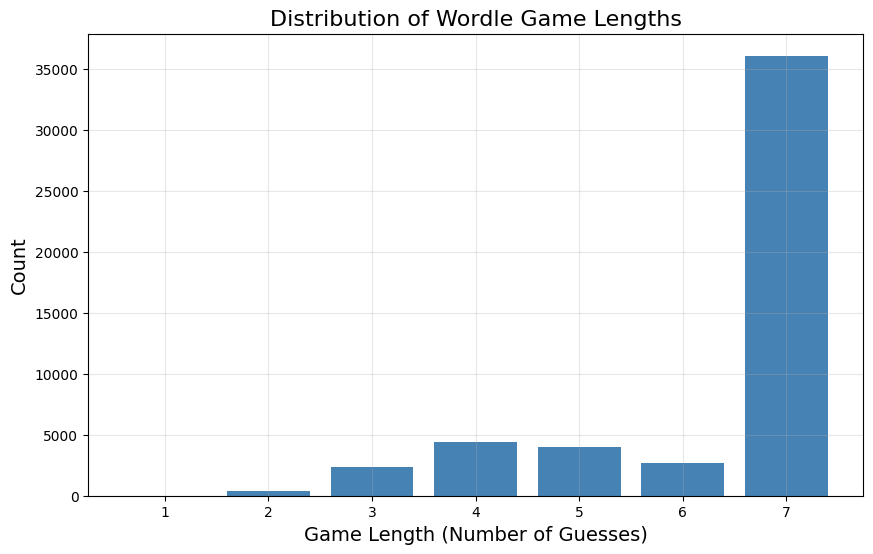

Win Rate: 27.85%
Average Game Length: 6.29 guesses
Average Reward: 67.26


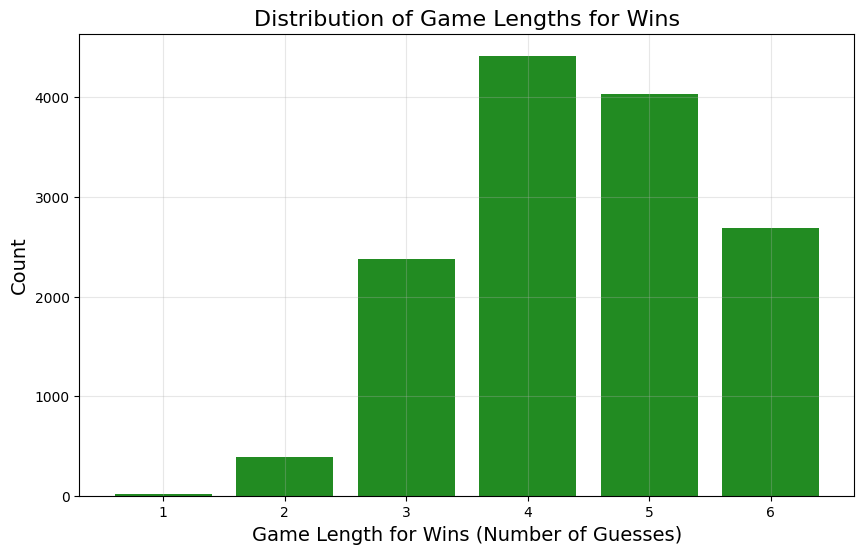

In [17]:
# Training the Q-learning agent
def train_and_evaluate(num_episodes=50000, epsilon=0.1, alpha=0.05, gamma=0.5):
    # Create environment
    env = WordleMetaEnv()
    
    # Train the agent
    print("Training Q-learning agent...")
    Q, stats = Q_Learning(env, num_episodes=num_episodes, epsilon=epsilon, alpha=alpha, gamma=gamma)
    
    return Q, stats

# Run the training and evaluation

Q, stats = train_and_evaluate(num_episodes=50000)
plot_game_statistics(stats)

In [23]:
Q

defaultdict(<function __main__.Q_Learning.<locals>.<lambda>()>,
            {(0,
              0,
              0): array([23.17670536, 22.73346505, 23.15316684, 23.48572855, 23.27023874,
                    23.2394098 ]),
             (0,
              0,
              5): array([25.7812083 , 27.44723525, 26.94809394, 21.32095864, 26.7219584 ,
                    25.50988622]),
             (1,
              0,
              4): array([25.62266827, 29.63774137, 32.0955068 , 26.24498712, 31.93356185,
                    32.0855347 ]),
             (1,
              2,
              2): array([26.19300363, 31.3371342 , 35.45497641, 33.02833361, 33.28546799,
                    36.64005433]),
             (0,
              2,
              3): array([24.95795228, 29.51625893, 27.65976891, 26.65460307, 28.70118075,
                    31.00569154]),
             (0,
              1,
              4): array([25.70519579, 27.00116665, 26.74584486, 23.87029974, 28.26145786,
                 

100%|██████████| 2309/2309 [00:09<00:00, 249.97it/s]


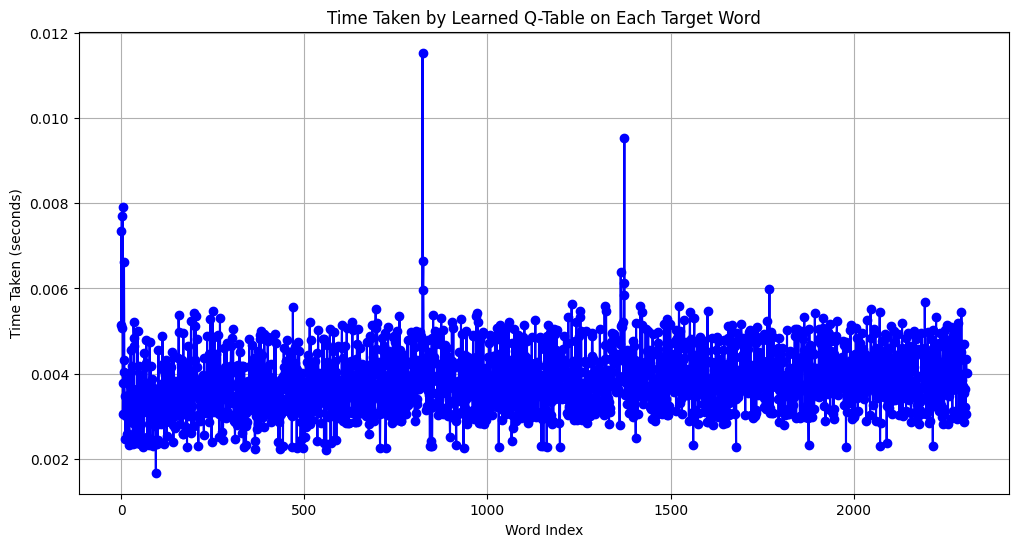

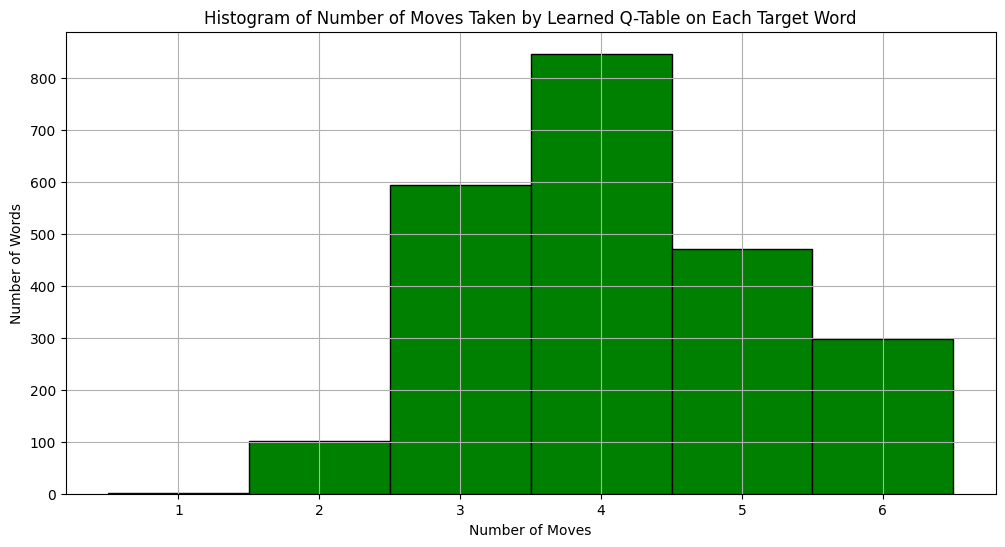

In [27]:
def run_episode_for_target(target, Q):
    # Use the meta environment which provides the step() function
    env = WordleMetaEnv()
    env.reset()
    # Override the target word in the underlying WordleQEnv:
    env.env.target_word = target  
    # Reset any counters in the underlying environment
    env.env.attempts = 0  
    env.env.guessed_words = []
    
    done = False
    state = (0, 0, 0)
    moves = 0

    start_time = time.time()
    
    while not done:
        # Choose the action with the highest Q value if available, else choose randomly
        if state in Q:
            action = np.argmax(Q[state])
        else:
            action = random.choice(env.agent.action_space)
            
        state, reward, done = env.step(action)
        moves += 1
    
    elapsed = time.time() - start_time
    return elapsed, moves

# Iterate over all target words and record the time and moves for each episode.
times = []
moves_list = []
for word in tqdm(target_words):
    t, m = run_episode_for_target(word, Q)
    times.append(t)
    moves_list.append(m)

# Plot time taken per word
plt.figure(figsize=(12, 6))
plt.plot(range(len(target_words)), times, marker='o', linestyle='-', color='blue')
plt.xlabel("Word Index")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken by Learned Q-Table on Each Target Word")
plt.grid(True)
plt.show()

# Plot histogram of number of moves per word
plt.figure(figsize=(12, 6))
plt.hist(moves_list, bins=range(1, max(moves_list) + 2), edgecolor='black', color='green', align='left')
plt.xlabel("Number of Moves")
plt.ylabel("Number of Words")
plt.title("Histogram of Number of Moves Taken by Learned Q-Table on Each Target Word")
plt.xticks(range(1, max(moves_list) + 1))
plt.grid(True)
plt.show()

100%|██████████| 2309/2309 [00:09<00:00, 237.80it/s]


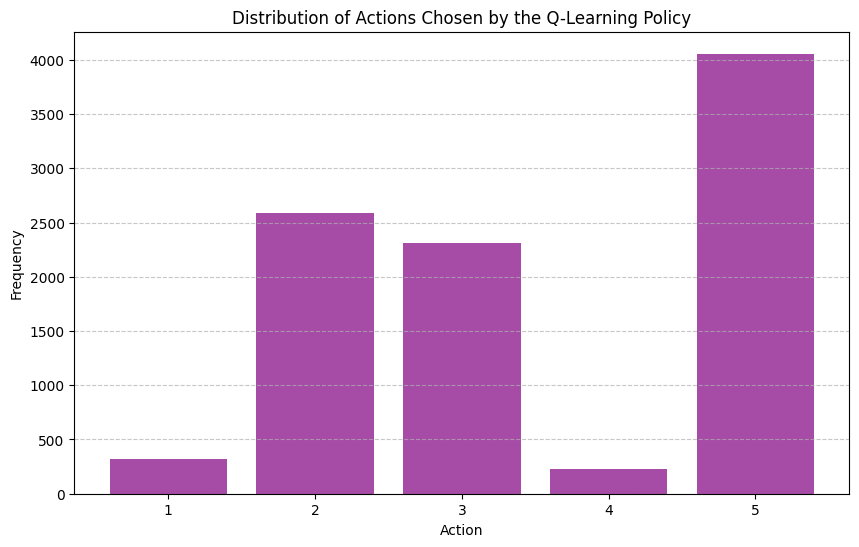

In [30]:
from collections import Counter

def run_episode_for_target(target, Q):
    # Use the meta environment which has the step() method.
    env = WordleMetaEnv()
    env.reset()
    # Override the target word in the underlying WordleQEnv.
    env.env.target_word = target  
    env.env.attempts = 0  
    env.env.guessed_words = []
    
    done = False
    state = (0, 0, 0)
    moves = 0
    actions_chosen = []  # Record the actions chosen during this episode

    start_time = time.time()
    
    while not done:
        # Choose the action with the highest Q value if available, otherwise choose randomly.
        if state in Q:
            action = np.argmax(Q[state])
        else:
            action = random.choice(env.agent.action_space)
        
        actions_chosen.append(action)
        state, reward, done = env.step(action)
        moves += 1
    
    elapsed = time.time() - start_time
    return elapsed, moves, actions_chosen

# Collect actions chosen across all episodes.
all_actions = []
times = []
moves_list = []
for word in tqdm(target_words):
    t, m, actions = run_episode_for_target(word, Q)
    times.append(t)
    moves_list.append(m)
    all_actions.extend(actions)

# Compute the frequency distribution of actions.
action_counts = Counter(all_actions)
actions = sorted(action_counts.keys())
counts = [action_counts[a] for a in actions]

# Plot the histogram of actions chosen.
plt.figure(figsize=(10, 6))
plt.bar(actions, counts, color='purple', alpha=0.7)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Distribution of Actions Chosen by the Q-Learning Policy")
plt.xticks(actions)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def evaluate_q_table(Q, word_dataset, env_class, max_steps=7):
    """
    Evaluate the learned Q-table on a dataset of words.
    
    Args:
        Q (defaultdict): The learned Q-table from Q-learning
        word_dataset (list): List of words to evaluate
        env_class: The environment class to create new instances
        max_steps (int): Maximum number of guesses allowed
    
    Returns:
        dict: Statistics about the evaluation
    """
    num_words = len(word_dataset)
    guesses_per_word = []
    wins = []
    
    print(f"Evaluating Q-table on {num_words} words...")
    
    for word in tqdm(word_dataset):
        # Create a new environment instance with the target word
        env = env_class()
        state = env.reset()
        
        done = False
        num_guesses = 0
        
        while not done and num_guesses < max_steps:
            # Select the best action according to Q-table
            action = np.argmax(Q[state])
            state, reward, done = env.step(action)
            num_guesses += 1
        
        # Record if the word was guessed correctly and how many attempts it took
        if env.win == 'win':
            wins.append(1)
            guesses_per_word.append(num_guesses)
        else:
            wins.append(0)
            guesses_per_word.append(max_steps)  # If failed, assign max guesses
    
    # Calculate statistics
    win_rate = np.mean(wins) * 100
    avg_guesses = np.mean(guesses_per_word)
    guess_distribution = np.bincount(guesses_per_word, minlength=max_steps+1)[1:]
    
    stats = {
        'win_rate': win_rate,
        'avg_guesses': avg_guesses,
        'guess_distribution': guess_distribution,
        'guesses_per_word': guesses_per_word,
        'wins': wins
    }
    
    return stats

def plot_evaluation_results(stats, max_steps=7):
    """
    Plot the evaluation results.
    
    Args:
        stats (dict): Evaluation statistics
        max_steps (int): Maximum number of guesses allowed
    """
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot guess distribution
    guess_distribution = stats['guess_distribution']
    guess_labels = [f"{i}" for i in range(1, len(guess_distribution)+1)]
    
    ax1.bar(guess_labels, guess_distribution)
    ax1.set_title('Distribution of Number of Guesses')
    ax1.set_xlabel('Number of Guesses')
    ax1.set_ylabel('Count')
    
    # Add win rate and average guesses as text
    win_rate_text = f"Win Rate: {stats['win_rate']:.2f}%"
    avg_guesses_text = f"Avg Guesses: {stats['avg_guesses']:.2f}"
    ax1.text(0.05, 0.95, win_rate_text, transform=ax1.transAxes, verticalalignment='top')
    ax1.text(0.05, 0.87, avg_guesses_text, transform=ax1.transAxes, verticalalignment='top')
    
    # Plot cumulative distribution
    cumulative_dist = np.cumsum(guess_distribution) / sum(guess_distribution) * 100
    
    ax2.plot(guess_labels, cumulative_dist, marker='o')
    ax2.set_title('Cumulative Distribution of Number of Guesses')
    ax2.set_xlabel('Number of Guesses')
    ax2.set_ylabel('Cumulative Percentage')
    ax2.set_ylim([0, 100])
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def load_word_dataset(file_path=None):
    """
    Load a dataset of words for evaluation.
    
    Args:
        file_path (str): Path to the word dataset file
        
    Returns:
        list: List of words
    """
    if file_path:
        try:
            with open(file_path, 'r') as f:
                words = [line.strip() for line in f if len(line.strip()) == 5]
            return words
        except Exception as e:
            print(f"Error loading word dataset: {e}")
            print("Using sample dataset instead.")
    
    # Sample dataset of common 5-letter words if no file is provided or loading fails
    sample_words = [
        "about", "which", "their", "there", "would", "other", "these", "first", 
        "water", "after", "where", "right", "think", "three", "years", "place", 
        "small", "large", "again", "house", "world", "below", "asked", "going", 
        "large", "until", "along", "came", "might", "close", "night", "whole", 
        "heard", "order", "early", "table", "words", "money", "music", "earth", 
        "paper", "often", "group", "river", "white", "story", "black", "young"
    ]
    
    return sample_words

In [19]:
Q = Q  # Use the Q-table from your training
    
    # Load your word dataset
words = load_word_dataset("target_words.txt")  # Replace with your dataset path

# If you don't have a separate dataset, you can use a subset of the training data
# Or use the sample dataset from the load_word_dataset function

# Evaluate the Q-table
eval_stats = evaluate_q_table(Q, words, WordleMetaEnv)

# Plot the results
plot_evaluation_results(eval_stats)

# Print detailed statistics
print(f"Win Rate: {eval_stats['win_rate']:.2f}%")
print(f"Average Guesses: {eval_stats['avg_guesses']:.2f}")
print(f"Guess Distribution: {eval_stats['guess_distribution']}")

Evaluating Q-table on 2309 words...


  0%|          | 0/2309 [00:00<?, ?it/s]


TypeError: __init__() got an unexpected keyword argument 'target_word'


Action Preference Analysis:
Action 0 (Random): Preferred in 1 states (4.55%)
Action 1 (Avoid Absent Letters): Preferred in 4 states (18.18%)
Action 2 (Use Greens & Avoid Absent): Preferred in 4 states (18.18%)


ValueError: 'label' must be of length 'x'

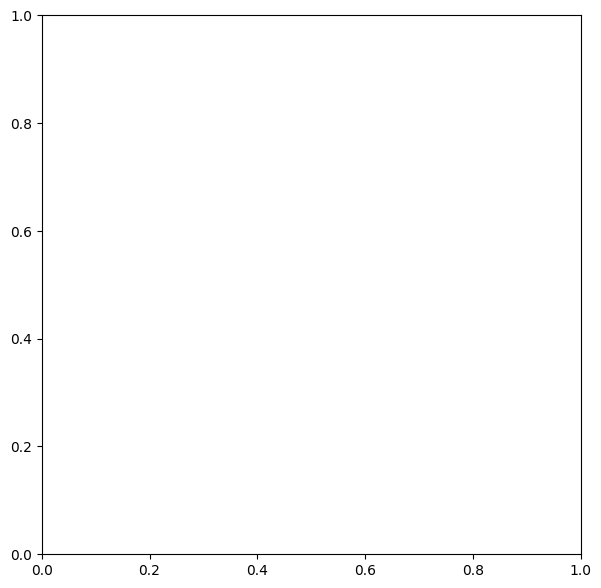

In [16]:
# Additional analysis: Most chosen actions
print("\nAction Preference Analysis:")
# Determine the number of actions from the Q-table
num_actions = len(next(iter(Q.values())))

# Create a dictionary to track action usage for each state
state_action_counts = defaultdict(lambda: np.zeros(num_actions))

# Count the actions taken for each state in the Q-table
for state, action_values in Q.items():
    best_action = np.argmax(action_values)
    state_action_counts[state][best_action] += 1

# Count how many times each action was the best action across all states
action_counts = np.zeros(num_actions)
for action_values in state_action_counts.values():
    best_action = np.argmax(action_values)
    action_counts[best_action] += 1
    
# Print the results
action_names = ["Random", "Avoid Absent Letters", "Use Greens & Avoid Absent"]
total_states = len(state_action_counts)

for i, (count, name) in enumerate(zip(action_counts, action_names)):
    percentage = (count / total_states) * 100 if total_states > 0 else 0
    print(f"Action {i} ({name}): Preferred in {count:.0f} states ({percentage:.2f}%)")

# Plot the action distribution as a pie chart
plt.figure(figsize=(10, 7))
plt.pie(action_counts, labels=action_names, autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=(0.05, 0.05, 0.05))
plt.title('Proportion of States Where Each Action is Optimal', fontsize=16)
plt.axis('equal')
plt.show()

In [ ]:

qouts9 = []
souts9 = []
wouts9 = []
# why loop?
for i in range(0,1):
    # print(i)
    tmpq, tmps, tmpw = Q_Learning(WordleMetaEnv(), 
                           50000, epsilon=0.1,alpha=0.05, discount_factor=0.05, prints=False)
    qouts9.append(tmpq)
    souts9.append(tmps)
    wouts9.append(tmpw)
print(np.mean([sum(x) for x in wouts9]))

  0%|          | 0/50000 [00:00<?, ?it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  0%|          | 54/50000 [00:00<03:05, 268.85it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  0%|          | 112/50000 [00:00<02:57, 280.60it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  0%|          | 141/50000 [00:00<02:59, 277.72it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  0%|          | 169/50000 [00:00<03:00, 276.57it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  0%|          | 199/50000 [00:00<02:57, 281.32it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  0%|          | 228/50000 [00:00<03:01, 274.76it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 256/50000 [00:00<03:24, 242.70it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 287/50000 [00:01<03:13, 257.25it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 318/50000 [00:01<03:04, 269.75it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 347/50000 [00:01<03:00, 275.42it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 377/50000 [00:01<02:56, 281.30it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 407/50000 [00:01<02:53, 286.64it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 436/50000 [00:01<02:52, 286.80it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 465/50000 [00:01<02:53, 285.69it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 495/50000 [00:01<02:52, 286.37it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert

  1%|          | 548/50000 [00:01<02:58, 277.53it/s]

assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert
assert


KeyboardInterrupt: 

In [ ]:
print(tmpq.items())

dict_items([((0, 0), array([16.55222852, 16.5270747 , 16.56105577])), ((0, 5), array([18.3353927 , 18.22402975, 18.68329881])), ((1, 4), array([18.05217031, 18.93978063, 20.87587281])), ((2, 3), array([19.28971455, 19.62156275, 24.44213028])), ((4, 1), array([21.29431218, 21.74559082, 31.27736015])), ((3, 2), array([21.15202388, 20.78218593, 26.80575965])), ((5, 0), array([0., 0., 0.]))])


In [ ]:
qouts9

[defaultdict(<function __main__.qLearning.<locals>.<lambda>()>,
             {(0, 0): array([16.55222852, 16.5270747 , 16.56105577]),
              (0, 5): array([18.3353927 , 18.22402975, 18.68329881]),
              (1, 4): array([18.05217031, 18.93978063, 20.87587281]),
              (2, 3): array([19.28971455, 19.62156275, 24.44213028]),
              (4, 1): array([21.29431218, 21.74559082, 31.27736015]),
              (3, 2): array([21.15202388, 20.78218593, 26.80575965]),
              (5, 0): array([0., 0., 0.])})]

In [ ]:
souts9

[Stats(episode_lengths=array([5., 5., 5., ..., 5., 5., 5.]), episode_rewards=array([106., 100., 104., ..., 102., 100., 106.]))]

In [ ]:
2

2

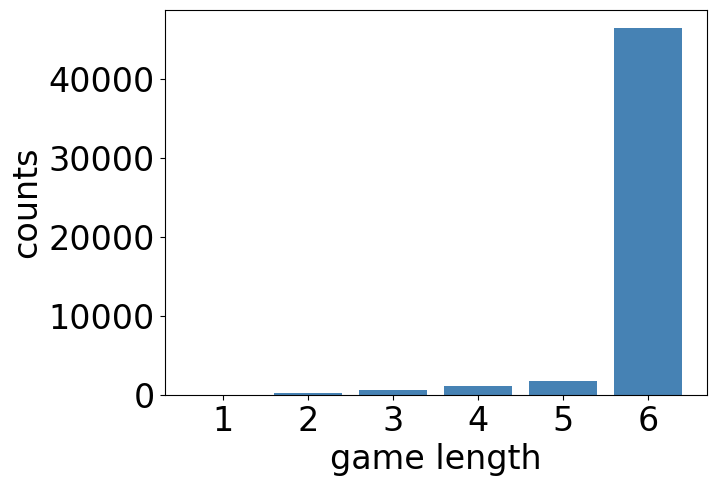

In [ ]:

plt.rcParams['figure.figsize']=7,5
# plt.style.use('seaborn-white')
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams["axes.edgecolor"] = "black"
#plt.rcParams["axes.linewidth"] = 2
labels, counts = np.unique(souts9[0].episode_lengths+1, return_counts=True)
plt.bar(labels, counts, align='center', color='steelblue')

#plt.hist(s1.episode_lengths+1, bins=10, align='mid')
#plt.title('10,000 trials', fontsize=24)
plt.xlabel('game length', fontsize=24)
plt.ylabel('counts', fontsize=24)
plt.gca().set_xticks(labels)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [ ]:
labels, counts

(array([1., 2., 3., 4., 5., 6.]),
 array([   25,   197,   612,  1082,  1681, 46403]))

In [ ]:
print(qouts9, souts9, wouts9)

[defaultdict(<function qLearning.<locals>.<lambda> at 0x11deb5790>, {(0, 0): array([16.55222852, 16.5270747 , 16.56105577]), (0, 5): array([18.3353927 , 18.22402975, 18.68329881]), (1, 4): array([18.05217031, 18.93978063, 20.87587281]), (2, 3): array([19.28971455, 19.62156275, 24.44213028]), (4, 1): array([21.29431218, 21.74559082, 31.27736015]), (3, 2): array([21.15202388, 20.78218593, 26.80575965]), (5, 0): array([0., 0., 0.])})] [Stats(episode_lengths=array([5., 5., 5., ..., 5., 5., 5.]), episode_rewards=array([106., 100., 104., ..., 102., 100., 106.]))] [array([0., 0., 0., ..., 0., 0., 0.])]


In [ ]:
print

<function print>

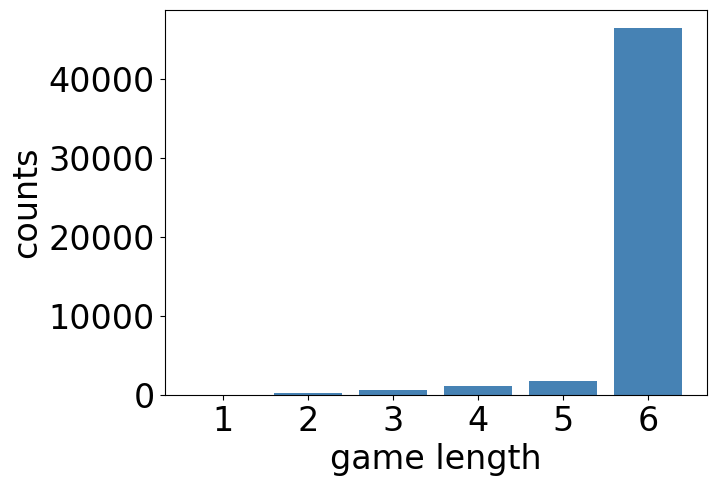

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize']=7,5
# plt.style.use('seaborn-white')
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams["axes.edgecolor"] = "black"
#plt.rcParams["axes.linewidth"] = 2
labels, counts = np.unique(souts9[0].episode_lengths+1, return_counts=True)
plt.bar(labels, counts, align='center', color='steelblue')

#plt.hist(s1.episode_lengths+1, bins=10, align='mid')
#plt.title('10,000 trials', fontsize=24)
plt.xlabel('game length', fontsize=24)
plt.ylabel('counts', fontsize=24)
plt.gca().set_xticks(labels)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [ ]:
## count of times hitting on first or second guess
print('num wins on first try:', len(np.where(souts9[0].episode_lengths+1==1)[0]))
print('num wins on second try:', len(np.where(souts9[0].episode_lengths+1==2)[0]))
print('num wins on third try:', len(np.where(souts9[0].episode_lengths+1==3)[0]))


num wins on first try: 25
num wins on second try: 197
num wins on third try: 612
